In [16]:
import numpy as np
import pandas as pd
import catboost as cat
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,log_loss
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
trainData = pd.read_csv('data/sample.csv')

In [18]:
trainData

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.000,9.545,9.265,8.110,8.430,7.150,0.180,...,4.950,1.730,1.800,4.800,3.150,10.665,10.465,16.645,5.750,10.37
1,1,9.10,13.533,40.900,8.770,9.265,6.015,10.070,7.150,1.107,...,20.050,9.530,7.695,4.550,6.950,2.040,5.200,5.725,2.950,2.23
2,2,8.21,3.710,5.420,8.770,9.265,4.550,10.070,7.150,0.020,...,4.580,3.025,3.960,4.935,4.950,4.725,6.075,6.750,3.500,3.17
3,3,8.39,8.700,8.100,9.500,9.200,5.200,8.670,6.670,0.280,...,8.450,2.070,1.730,6.300,4.700,3.500,6.200,8.670,2.900,7.37
4,4,8.07,8.050,8.650,7.960,9.265,3.290,10.070,7.150,0.360,...,2.020,1.730,0.760,4.800,4.970,3.950,2.800,8.400,3.500,3.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,8.08,6.250,8.300,7.795,9.265,5.690,8.555,6.335,0.565,...,14.575,0.636,1.640,4.235,4.100,2.800,3.950,7.695,3.540,2.50
3496,3496,8.09,6.630,6.630,8.370,7.600,0.636,8.430,7.150,1.300,...,4.580,1.730,1.800,4.900,3.150,2.040,6.075,8.415,2.155,2.90
3497,3497,9.95,8.367,8.433,8.770,6.170,5.800,10.400,7.200,0.430,...,20.050,1.440,1.800,4.867,4.833,4.725,4.950,8.400,6.625,4.20
3498,3498,9.52,10.000,6.630,9.545,9.265,3.290,8.980,2.310,0.300,...,20.050,9.530,7.695,10.700,5.400,4.725,3.300,6.750,6.625,5.00


In [19]:
def generateXY(trainData):
    x = trainData.drop(columns=['id','target'])
    x = x.fillna(method='ffill')
    x = x.fillna(0)
    y = trainData.target
    return x,y

In [20]:
def calculateRMSE(x,y,features,model):
    for i,val in enumerate(x.columns):
        if val not in features:
            x = x.drop(columns=val)
    X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.2, random_state=42)
    clf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_val)
    loss = mean_squared_error(y_val,prediction,squared=False)
    print(f"{model} has RMSE = {loss}")
    return clf

<Axes: >

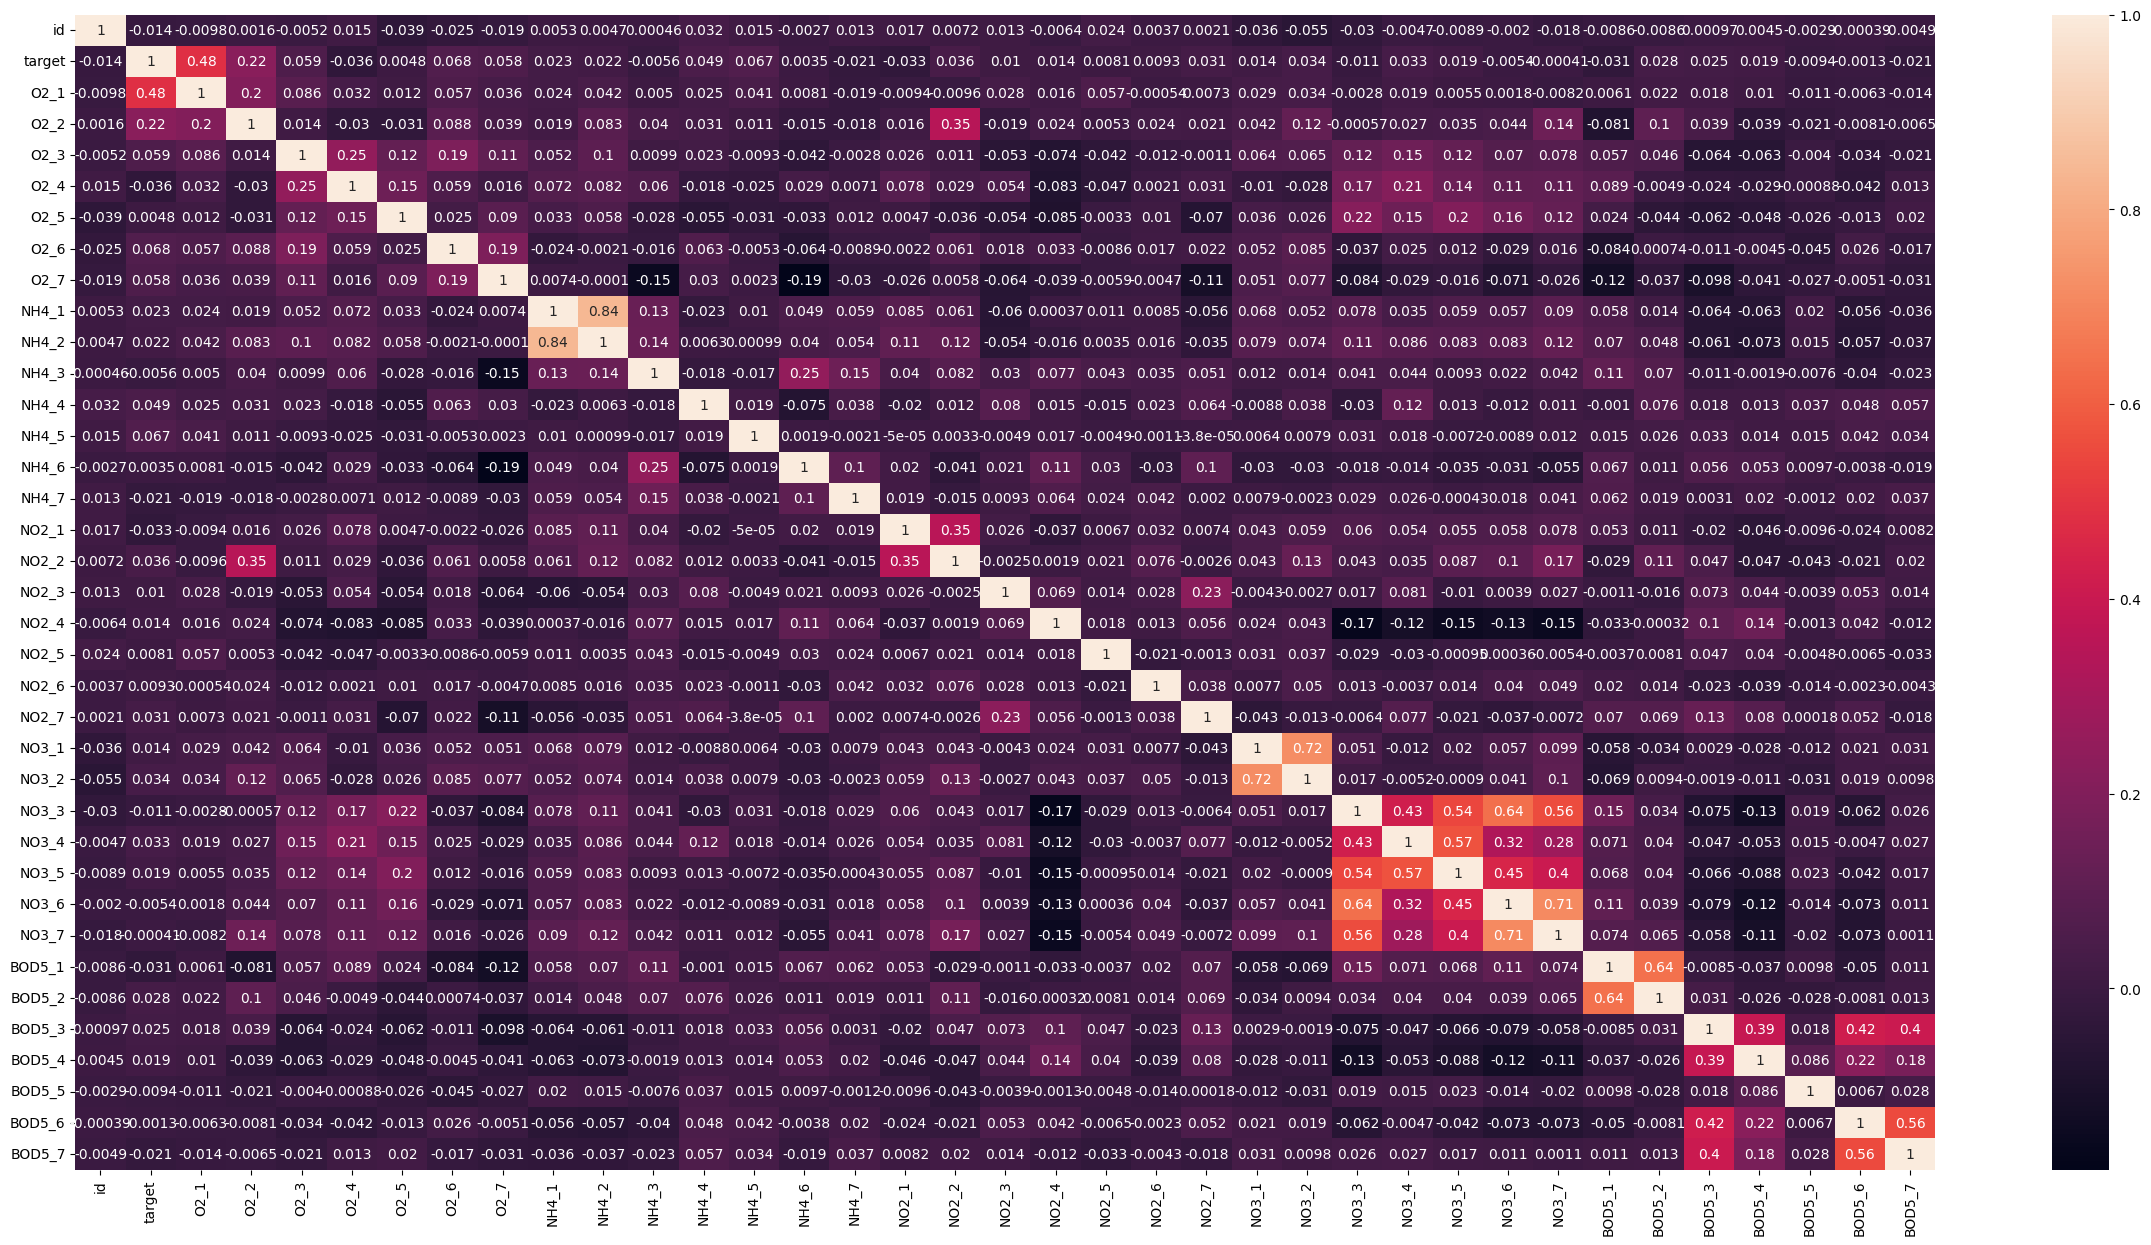

In [21]:
trainCorr = trainData.corr()
plt.figure(figsize=(30,15))
sns.heatmap(trainCorr, annot=True)

In [22]:
threshold = 0.05
corr=abs(trainCorr['target'])
result = corr[corr>threshold]
result.sort_values(ascending=False)

target    1.000000
O2_1      0.481100
O2_2      0.222749
O2_6      0.068118
NH4_5     0.066669
O2_3      0.059053
O2_7      0.058312
Name: target, dtype: float64

In [23]:
columns = trainData.columns.tolist()
highCorrFeature = []
for i in range(5,len(columns)):
    if columns[i] in highCorrFeature:
        continue
    for j in range(i,len(columns)):
        if columns[j] in highCorrFeature:
            continue
        if i != j:
            c = trainData[[columns[i],columns[j]]].corr()
            val = c[columns[j]][0]
            if val > 0.5:
                print(f"{columns[i]} and {columns[j]} has high correlation {val}")
                highCorrFeature.append(columns[j])
                
print(f"\nSize of original data {trainData.shape[1]}, \
number of high correlation features {len(highCorrFeature)}")

NH4_1 and NH4_2 has high correlation 0.8414882929192122
NO3_1 and NO3_2 has high correlation 0.7196981136988061
NO3_3 and NO3_5 has high correlation 0.5421141239762859
NO3_3 and NO3_6 has high correlation 0.6412964900302389
NO3_3 and NO3_7 has high correlation 0.5560658153589086
BOD5_1 and BOD5_2 has high correlation 0.6448950380251364
BOD5_6 and BOD5_7 has high correlation 0.5551490469957154

Size of original data 37, number of high correlation features 7


In [24]:
x = trainData.drop(columns=highCorrFeature)
featurePC = x.columns.tolist()
print("Selected features: ",featurePC)
x,y = generateXY(trainData)
calculateRMSE(x,y,featurePC,'Pearson Correlation')

Selected features:  ['id', 'target', 'O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_5', 'O2_6', 'O2_7', 'NH4_1', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7', 'NO2_1', 'NO2_2', 'NO2_3', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7', 'NO3_1', 'NO3_3', 'NO3_4', 'BOD5_1', 'BOD5_3', 'BOD5_4', 'BOD5_5', 'BOD5_6']
Pearson Correlation has RMSE = 1.1421052724730754


RandomForestRegressor(max_depth=7, n_estimators=1000, n_jobs=-1,
                      random_state=42)

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def cal_vif(x):
    thresh = 2
    output = pd.DataFrame()
    k = x.shape[1]
    vif = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
    for i in range(1,k):
        a = np.argmax(vif)
        print('Max vif is for variable no:',a)
        if (vif[a]<=thresh):
            break
        if (i==1):
            output = x.drop(x.columns[a],axis=1)
            vif = [variance_inflation_factor(output.values,j) for j in range(output.shape[1])]
        elif (i>1):
            output = output.drop(output.columns[a],axis=1)
            vif = [variance_inflation_factor(output.values,j) for j in range(output.shape[1])]
    return output

x,y = generateXY(trainData)
x = cal_vif(x)
featureVIF = x.columns.tolist()
print("Selected_features: ",featureVIF)
calculateRMSE(x,y,featureVIF,'Variance Inflation Factor')

Max vif is for variable no: 5
Max vif is for variable no: 2
Max vif is for variable no: 2
Max vif is for variable no: 26
Max vif is for variable no: 3
Max vif is for variable no: 28
Max vif is for variable no: 3
Max vif is for variable no: 0
Max vif is for variable no: 24
Max vif is for variable no: 18
Max vif is for variable no: 16
Max vif is for variable no: 23
Max vif is for variable no: 20
Max vif is for variable no: 19
Max vif is for variable no: 11
Max vif is for variable no: 1
Max vif is for variable no: 17
Max vif is for variable no: 17
Max vif is for variable no: 2
Max vif is for variable no: 13
Max vif is for variable no: 5
Max vif is for variable no: 8
Max vif is for variable no: 11
Max vif is for variable no: 0
Max vif is for variable no: 3
Max vif is for variable no: 1
Max vif is for variable no: 4
Max vif is for variable no: 6
Selected_features:  ['NH4_2', 'NH4_5', 'NO2_1', 'NO2_2', 'NO2_6', 'NO2_7', 'NO3_1', 'NO3_6']
Variance Inflation Factor has RMSE = 1.638308375838121

RandomForestRegressor(max_depth=7, n_estimators=1000, n_jobs=-1,
                      random_state=42)

In [26]:
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import warnings
warnings.filterwarnings('ignore')
x,y = generateXY(trainData)
X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.2, random_state=42)
clf = CatBoostRegressor(iterations=10,metric_period=500,verbose=False)
sfs1 = sfs(clf,k_features=5,forward=True,floating=False, verbose=1, cv=3)
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.7s finished
Features: 1/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    2.8s finished
Features: 2/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    2.8s finished
Features: 3/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.9s finished
Features: 4/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    2.9s finished
Features: 5/5

In [27]:
feat_cols = list(sfs1.k_feature_idx_)
featureSFS = x.columns[feat_cols].tolist()
print("Selected features:", featureSFS)
calculateRMSE(x,y,featureSFS,'Step Forward Selection')

Selected features: ['O2_1', 'O2_2', 'O2_4', 'O2_5', 'BOD5_3']
Step Forward Selection has RMSE = 1.2347321317342794


RandomForestRegressor(max_depth=7, n_estimators=1000, n_jobs=-1,
                      random_state=42)

In [28]:
x,y = generateXY(trainData)
import statsmodels.api as sm
cols = list(x.columns)
pmax = 1
while (len(cols)>0):
    p = []
    x_1 = x[cols]
    x_1 = sm.add_constant(x_1)
    model = sm.OLS(y,x_1).fit()
    p = pd.Series(model.pvalues.values[1:],index=cols)
    pmax = max(p)
    features_with_p_max = p.idxmax()
    if (pmax>0.05):
        cols.remove(features_with_p_max)
    else:
        break
featureBE=cols
print("Selected features: ",featureBE)
calculateRMSE(x,y,featureBE,'Backward Elimination')

Selected features:  ['O2_1', 'O2_2', 'O2_4', 'O2_7', 'NH4_4', 'NH4_5', 'NO2_7']
Backward Elimination has RMSE = 1.1699869571352985


RandomForestRegressor(max_depth=7, n_estimators=1000, n_jobs=-1,
                      random_state=42)

In [29]:
from sklearn.feature_selection import RFE
x,y = generateXY(trainData)
clf = CatBoostRegressor(iterations=100,metric_period=500,verbose=False)
rfe = RFE(clf)
X_rfe = rfe.fit_transform(x,y)
clf.fit(X_rfe,y)
cols = list(x.columns)
temp = pd.Series(rfe.support_,index = cols)
featureRFE = temp[temp==True].index.tolist()
print("Selected features: ",featureRFE)
calculateRMSE(x,y,featureRFE,'Recursive Feature Elimination')

Selected features:  ['O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_5', 'NH4_1', 'NH4_2', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NO3_1', 'NO3_6', 'BOD5_1', 'BOD5_2', 'BOD5_5', 'BOD5_6']
Recursive Feature Elimination has RMSE = 1.1427434638453806


RandomForestRegressor(max_depth=7, n_estimators=1000, n_jobs=-1,
                      random_state=42)

In [30]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LassoCV
x,y = generateXY(trainData)
reg = LassoCV(cv=5,n_alphas=200,tol=1e-4,fit_intercept=False)
reg.fit(x,y)
print("Best score: ", reg.score(x,y))
coef = pd.Series(reg.coef_, index=x.columns)
print("Lasso picked " + str(sum(coef != 0))+ " variables and eliminated the other " + str(sum(coef ==0)) + " variables")
imp_coef = coef.sort_values()
featureEM = imp_coef[imp_coef>0].index.tolist()
print("Selected features: ",featureEM)
calculateRMSE(x,y,featureEM,'Embedded Method')

Best score:  0.2015839349573032
Lasso picked 15 variables and eliminated the other 20 variables
Selected features:  ['NH4_5', 'NO3_5', 'NO3_4', 'O2_5', 'NH4_4', 'BOD5_5', 'O2_4', 'BOD5_3', 'O2_2', 'BOD5_4', 'BOD5_2', 'O2_7', 'O2_3', 'O2_6', 'O2_1']
Embedded Method has RMSE = 1.1455490394511223


RandomForestRegressor(max_depth=7, n_estimators=1000, n_jobs=-1,
                      random_state=42)

Text(0.5, 1.0, 'Feature importance based on all selection techniques')

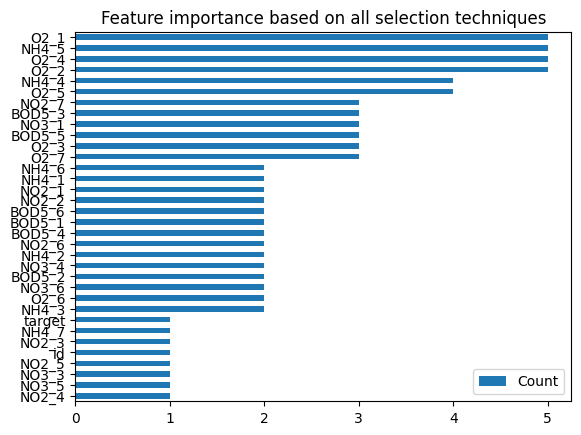

In [31]:
allfeature = featurePC + featureVIF + featureSFS + featureBE + featureRFE + featureEM
feature, count = np.unique(allfeature, return_counts=True)
featureCount = pd.DataFrame(count,index=feature, columns=['Count'])
featureCount = featureCount.sort_values(by=['Count'])
featureCount.plot(kind = "barh")
plt.rcParams["figure.figsize"] = (10,30)
plt.title("Feature importance based on all selection techniques")

In [32]:
selected_features = []
for i, val in enumerate(feature):
    if count[i] > 4:
        selected_features.append(val)
print("Final selected features: ", selected_features)
trainData = pd.read_csv('data/sample.csv')
x,y = generateXY(trainData)
clf = calculateRMSE(x,y,selected_features,"Final model")

Final selected features:  ['NH4_5', 'O2_1', 'O2_2', 'O2_4']
Final model has RMSE = 1.1556428545022717


In [34]:
trainData = pd.read_csv('data/sample.csv')
for i in trainData.columns:
    if i not in selected_features and i != "target" and i != "id":
        trainData[i] = 0
        
x,y = generateXY(trainData)
clf = calculateRMSE(x,y,selected_features,"Final model")

Final model has RMSE = 1.1556428545022717
